In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import math

In [2]:
refuge_df = pd.read_csv('../raw/gt/REFUGE - List.csv')
refuge_df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
refuge_df.columns = ['Image', 'Label']
refuge_gt_df = refuge_df.copy()
refuge_pred_df = pd.DataFrame(columns=['Image', 'Negative pred', 'Positive pred'])
for i in range(1, 5):
    jsonObj = pd.read_json(f'../raw/preds/refuge{i}.jsonl', lines=True)
    for iter, row in jsonObj.iterrows():
        image = row['instance']['content']
        preds = row['prediction']['confidences']
        if row['prediction']['displayNames'] == ['NRG', 'RG']:
            new_df = pd.DataFrame.from_dict({'Image':image, 'Negative pred': [preds[0]], 'Positive pred':[preds[1]]})
        else:
            new_df = pd.DataFrame.from_dict({'Image':image, 'Negative pred': [preds[1]], 'Positive pred':[preds[0]]})
        refuge_pred_df = pd.concat([refuge_pred_df, new_df])
        
refuge_pred_df.sort_values('Image', inplace=True)
refuge_df = refuge_df.merge(refuge_pred_df, on='Image', how='left')
refuge_df['Label'] = refuge_df['Label'].map(lambda x: 0 if x=='N' else 1)


gamma_df = pd.read_excel('../raw/gt/GAMMA_glaucoma_grading_training_GT.xlsx')
jsonObj = pd.read_json(f'../raw/preds/gamma predictions (100)', lines=True)

gamma_df.drop(['early', 'mid_advanced'], inplace=True, axis=1)
gamma_df.columns = ['Image', 'Label']
gamma_df['Label'] = 1-gamma_df['Label']
gamma_pred_df = pd.DataFrame(columns=['Image', 'Negative pred', 'Positive pred'])

for iter, row in jsonObj.iterrows():
    image = row['instance']['content']
    img_id = int(image.split('/')[-1].split('.')[0])
    preds = row['prediction']['confidences']
    if row['prediction']['displayNames'] == ['NRG', 'RG']:
        new_df = pd.DataFrame.from_dict({'Image':img_id, 'Negative pred': [preds[0]], 'Positive pred':[preds[1]]})
    else:
        new_df = pd.DataFrame.from_dict({'Image':img_id, 'Negative pred': [preds[1]], 'Positive pred':[preds[0]]})
    gamma_pred_df = pd.concat([gamma_pred_df, new_df])
gamma_pred_df.sort_values('Image', inplace=True)
gamma_df = gamma_df.merge(gamma_pred_df, on='Image', how='left')

airogs_df = pd.read_csv('../raw/gt/airogslabels weka balanced 2to1.csv')
airogs_df.columns = ['Image', 'Label']
airogs_df['Label'] = airogs_df['Label'].map(lambda x: 0 if x=='NRG' else 1)
list_weka = [f for f in os.listdir('../raw/preds/') if 'weka' in f]

airogs_pred_df = pd.DataFrame(columns=['Image', 'Negative pred', 'Positive pred'])
for file in list_weka:
    filepath = os.path.join('../raw/preds/', file)
    jsonObj = pd.read_json(filepath, lines=True)
    for iter, row in jsonObj.iterrows():
        image = row['instance']['content']
        preds = row['prediction']['confidences']
        if row['prediction']['displayNames'] == ['NRG', 'RG']:
            new_df = pd.DataFrame.from_dict({'Image':image, 'Negative pred': [preds[0]], 'Positive pred':[preds[1]]})
        else:
            new_df = pd.DataFrame.from_dict({'Image':image, 'Negative pred': [preds[1]], 'Positive pred':[preds[0]]})
        airogs_pred_df = pd.concat([airogs_pred_df, new_df])
        
airogs_pred_df.sort_values('Image', inplace=True)
airogs_df = airogs_df.merge(airogs_pred_df, on='Image', how='left')




In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    arr_value = array[idx]
    # if round(arr_value*100)> value * 100:
    #     idx += 1
    return  arr_value, idx

In [4]:
def plot_AUROC(y, probas, 
               bespoke_sens,
               bespoke_symbol,
               title, 
               color, 
               save=True, 
               fill_color=None, 
               show=False, legend_loc=1, 
               bbox_to_anchor=None):
    fpr, tpr, _ = roc_curve(y, probas[:, 1], drop_intermediate=True)
    auroc = roc_auc_score(y, probas[:, 1])
    spec95, spec95idx = find_nearest(fpr, 0.05)
    if title=='REFUGE':
        spec95idx += 1
    sens95 = tpr[spec95idx]
    line = np.linspace(0, 1, 50)
    plt.plot(line, line, color='black', linewidth=0.75, linestyle=(0, (5, 7)), alpha=0.15)
    # plt.title(title)
    spec95pt =  plt.plot(0.05, sens95, 'o', label=f'SE@{0.95:.0%}SP: {sens95:.3f} (CFDL)', color=color)
    curve,  = plt.plot(fpr, tpr, color=color, linewidth=1.5, label=f'AUC: {auroc:.3f}')
    bespoke_points = plt.plot(0.05, bespoke_sens, bespoke_symbol, color=color, label=f'SE@{.95:.0%}SP: {bespoke_sens:.3f} (bespoke model)')
    plt.xlabel('1-specificity')
    plt.ylabel('sensitivity')
    if fill_color:
        plt.fill_between(fpr, tpr, alpha=0.15, label=f'AUC: {auroc:.3f}', color=color)
    plt.xlim(-0.0, 1)
    plt.ylim(0, 1.01)
    if bbox_to_anchor:
        legend = plt.legend(handles=[curve] + spec95pt+bespoke_points, title=title, loc=legend_loc, bbox_to_anchor=bbox_to_anchor)
    else:
        legend = plt.legend(handles=[curve] + spec95pt+bespoke_points, title=title, loc=legend_loc)
    
    plt.gca().spines[['right', 'top']].set_visible(False)
    plt.gca().add_artist(legend)
    
    if save:
        plt.savefig(f'{title}.png')
    if show:
        plt.show()

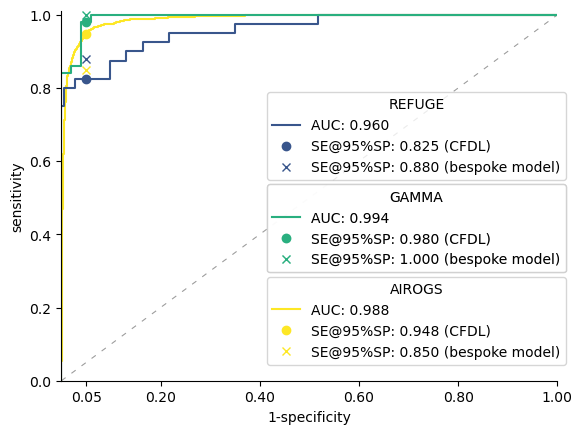

In [5]:
data = {}

y = airogs_df['Label'].values
probas = airogs_df[['Negative pred', 'Positive pred']].values

plot_AUROC(y, probas, 0.85, 'x', 'AIROGS', '#FDE725FF', False, False, False, 'upper left', (0.4, 0.3))

data['AIROGS'] = {'label': y, 'probas': probas, 'bespoke_sens': 0.85}

y = refuge_df['Label'].values
probas = refuge_df[['Negative pred', 'Positive pred']].values
plot_AUROC(y, probas, 0.88, 'x', 'REFUGE', '#39568CFF', False, False, False, 'upper left', (0.4, 0.80))

data['REFUGE'] = {'label': y, 'probas': probas, 'bespoke_sens': 0.88}


y = gamma_df['Label'].values
probas = gamma_df[['Negative pred', 'Positive pred']].values

plot_AUROC(y, probas, 1.0, 'x', 'GAMMA', '#29AF7FFF', False, False, False, 'upper left', (0.4, 0.55))
data['GAMMA'] = {'label': y, 'probas': probas, 'bespoke_sens': 1.0}



xticks = np.linspace(0, 1, 6)
xticks[0] = 0.05
plt.xticks(xticks)
plt.savefig('ALL.png')
plt.show()


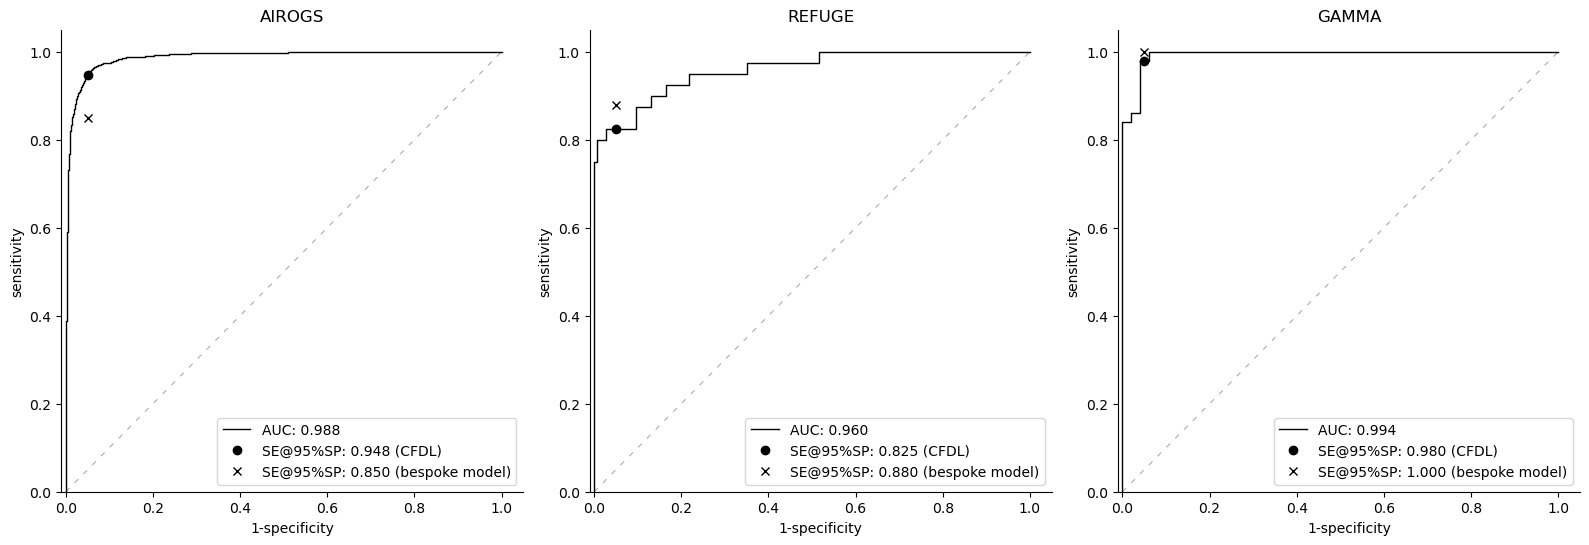

In [6]:

def plot_AUROCS(data, save=True, 
               fill_color=None, 
               show=False, legend_loc=1, 
               bespoke_symbol='x',
               bbox_to_anchor=None):
    fig, axs = plt.subplots(1, len(data))
    line = np.linspace(0, 1, 50)
    fig.set_size_inches(16,6)
    for i, (title, values) in enumerate(data.items()):
        ax = axs[i]
        ax.set_box_aspect(1)
        y, probas, bespoke_sens = values['label'], values['probas'], values['bespoke_sens']
        fpr, tpr, _ = roc_curve(y, probas[:, 1], drop_intermediate=True)
        auroc = roc_auc_score(y, probas[:, 1])
        spec95, spec95idx = find_nearest(fpr, 0.05)
        if title=='REFUGE':
            spec95idx += 1
        sens95 = tpr[spec95idx]

        ax.plot(line, line, color='black', linewidth=0.75, linestyle=(0, (5, 7)), alpha=0.35)
        curve,  = ax.plot(fpr, tpr, color='black', linewidth=1, label=f'AUC: {auroc:.3f}')
        spec95pt =  ax.plot(0.05, sens95, 'o', label=f'SE@{0.95:.0%}SP: {sens95:.3f} (CFDL)', color='black')
        bespoke_points = ax.plot(0.05, bespoke_sens, bespoke_symbol, color='black', label=f'SE@{.95:.0%}SP: {bespoke_sens:.3f} (bespoke model)')
        ax.set_xlabel('1-specificity')
        ax.set_ylabel('sensitivity')
        ax.set_ylim(0, 1.05)
        ax.set_xlim(-0.01, 1.05)
        ax.legend()
        ax.set_title(title)
        ax.spines[['right', 'top']].set_visible(False)
    fig.set_tight_layout('tight')
    return fig

fig = plot_AUROCS(data)
fig.savefig('ALL_COMBINED.png')